### Deforestation Detection Using Sentinel-1 SAR

GEOG 313: Advanced Geospatial w/ Python Final Project

In [1]:
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [2]:
start = "2015-01-01"
end = "2024-12-31"

In [3]:
import leafmap

m = leafmap.Map(center=[-5.0467299, 38.7375924], zoom=18, height="800px", google_map="SATELLITE")
#m.add_raster(mask)
m

Map(center=[-5.0467299, 38.7375924], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [5]:
aoi = (m.west, m.south, m.east, m.north)

In [6]:
import utils
search = utils.get_sar_pc(aoi, start, end)
stack = utils.items_to_xarray(search, aoi)
index = utils.calculate_index(stack, "RVI")
coarsened = utils.coarsen_image(index, scale = 3)
composite = utils.temporal_composite(coarsened)

Attempt 1: error not being able to apply polyfit to windowed construct?  However, when looking at the structure of 'construct' it says it is a dataarray, wich should have attribute `dataarray.polyfit`

In [13]:
def linear_trend(stack):
    trend = stack.polyfit(dim = "time", deg = 1)
    return trend


rolling = index.rolling(time = 3, center = True)
construct = rolling.construct("window_dim")

construct.reduce(linear_trend)

AttributeError: 'Array' object has no attribute 'polyfit'

attempt 2: using np.polyfit. Here I'm not sure what the name of the y axis is?

In [19]:
import numpy as np

rolling = index.rolling(time = 3, center = True)
construct = rolling.construct("window_dim")

rolling.reduce(np.polyfit(x = 'time', y = '', deg = 1))
 

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U4'), dtype('float64')) -> None

In [34]:
deseasoned = utils.deseason(composite)

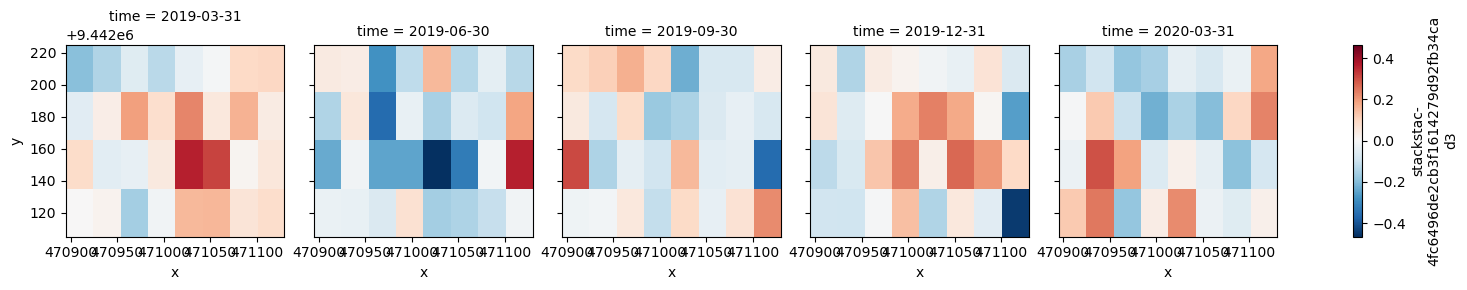

In [39]:

change = utils.img_change(deseasoned)
change.isel(time=[16, 17, 18, 19, 20]).plot.imshow(col="time", col_wrap=5)

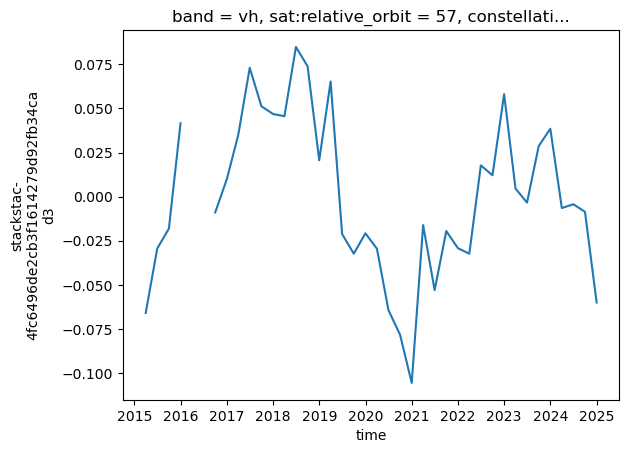

In [40]:
tsmean = deseasoned.mean(dim = ['y', 'x'], skipna = True)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
tsmean.plot(ax=ax)

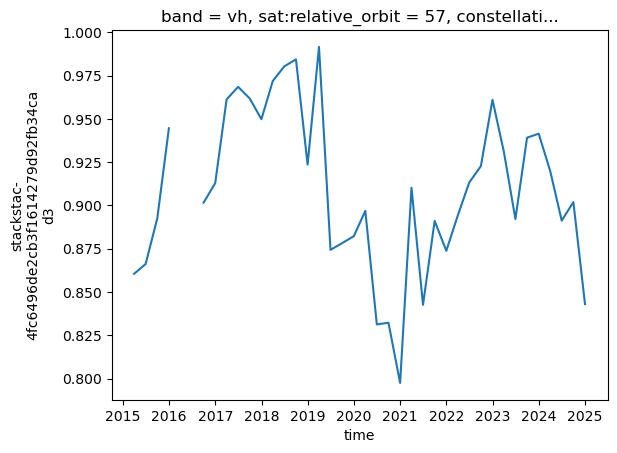

In [41]:
tsmean = composite.mean(dim = ['y', 'x'], skipna = True)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
tsmean.plot(ax=ax)

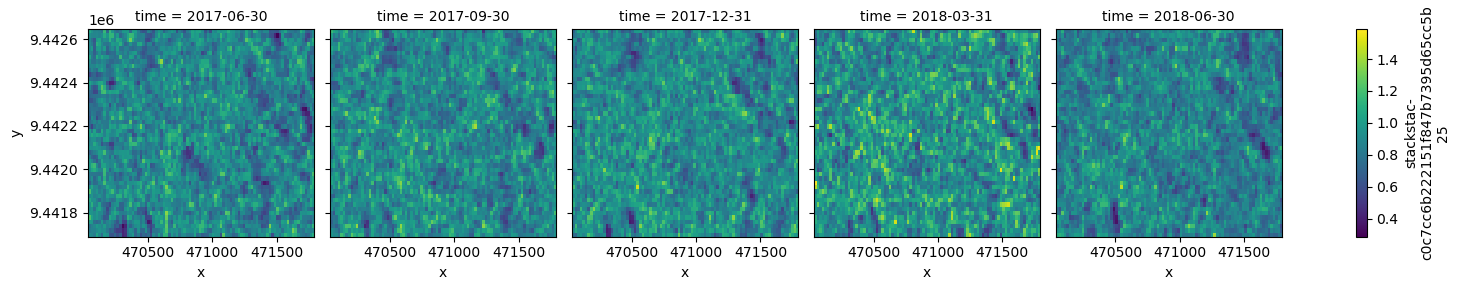

In [15]:
index = utils.calculate_index(composite, "RVI")
index.isel(time=[9, 10, 11, 12, 13]).plot.imshow(col="time", col_wrap=5)

In [24]:
stack.coords['year'] = ('time', stack.time.dt.year.data)

def linear_trend(stack):
    trend = stack.polyfit(dim = "time", deg = 1)
    return trend
 # np.polyfit(x = 'time', deg = 1)
import numpy as np 

rolling = index.rolling(time = 6, center = True)
aa = rolling.construct("window_dim")

aa.reduce(linear_trend)

AttributeError: 'Array' object has no attribute 'polyfit'

In [18]:
rolling.construct("window_dim")

<xarray.DataArray 'stackstac-bbeaa34406ffadba6c8abd1a85c85f40' (time: 235,
                                                                y: 25, x: 45,
                                                                window_dim: 6)> Size: 13MB
dask.array<sliding_window_view, shape=(235, 25, 45, 6), dtype=float64, chunksize=(6, 25, 45, 6), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 2kB 2015-01-...
    id                                     (time) <U66 62kB 'S1A_IW_GRDH_1SDV...
    band                                   <U2 8B 'vh'
  * x                                      (x) float64 360B 4.708e+05 ... 4.7...
  * y                                      (y) float64 200B 9.442e+06 ... 9.4...
    s1:orbit_source                        (time) <U8 8kB 'DOWNLINK' ... 'RES...
    ...                                     ...
    s1:total_slices                        (time) <U2 2kB '16' '9' ... '11' '11'
    start_datetime                         (time) <U32 30kB '2015-01-01 15:46...
    description                            <U173 692B 'Terrain-corrected gamm...
    title                                  <U41 164B 'VH: vertical transmit, ...
    raster:bands                           object 8B {'nodata': -32768, 'data...
    epsg                                   int64 8B 32737
Dimensions without coordinates: window_dim

In [7]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import stackstac
import os
import leafmap
import requests
from tqdm import tqdm
import pystac_client
import planetary_computer
from matplotlib import pyplot as plt
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=['landsat-8-c2-l2'],
    bbox=aoi,
    datetime='2015-01-01/2015-12-31'
)

items = search.get_all_items()
stack = stackstac.stack(items, 
                        assets=['SR_B4', 'SR_B5', 'QA_PIXEL'],
                        epsg=32737,
                        resolution=30,
                        bounds_latlon=aoi,
                       )

# mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
# bitmask = 0
# for field in mask_bitfields:
#     bitmask |= 1 << field

# bin(bitmask)

# qa = stack.sel(band="QA_PIXEL").astype("uint16")
# mask = qa & bitmask  # just look at those 4 bits

# cloud_free_stack = stack.where(mask == 0)

# sampled = cloud_free_stack.resample(time="1Q").median("time")

stack


<xarray.DataArray 'stackstac-93ad55ed54f534b96ea7ec90158fe886' (time: 0,
                                                                band: 0, y: 32,
                                                                x: 59)> Size: 0B
dask.array<fetch_raster_window, shape=(0, 0, 32, 59), dtype=float64, chunksize=(0, 0, 32, 59), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 0B 
    id       (time) float64 0B 
  * band     (band) float64 0B 
  * x        (x) float64 472B 4.7e+05 4.701e+05 ... 4.718e+05 4.718e+05
  * y        (y) float64 256B 9.443e+06 9.443e+06 ... 9.442e+06 9.442e+06
    epsg     int64 8B 32737
Attributes:
    spec:        RasterSpec(epsg=32737, bounds=(470040, 9441690, 471810, 9442...
    crs:         epsg:32737
    transform:   | 30.00, 0.00, 470040.00|\n| 0.00,-30.00, 9442650.00|\n| 0.0...
    resolution:  30

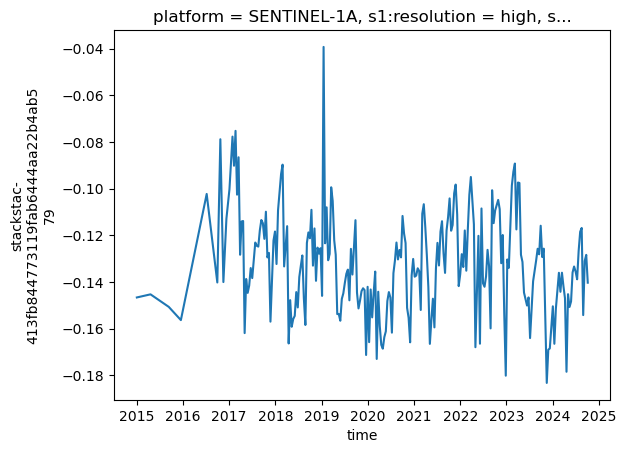

In [28]:
tsmean = index.mean(dim = ['y', 'x'], skipna = True)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
tsmean.plot(ax=ax)
#ax.set_ylim(0,1.2)


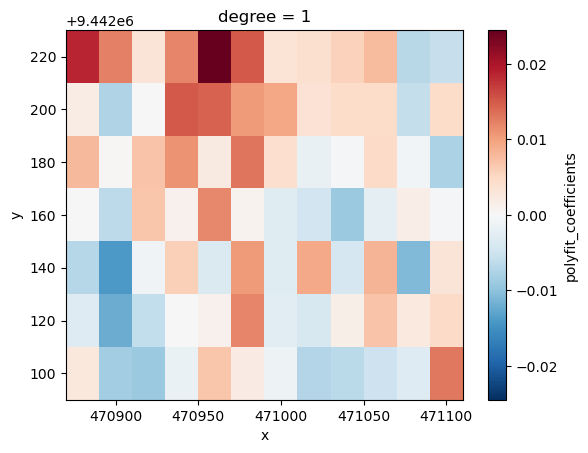

In [53]:
trends = utils.linear_trend(index)
linecoeff = trends.sel(degree = 1)

linecoeff.polyfit_coefficients.plot.imshow()